In [1]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from transformers import ViTImageProcessor, ViTForImageClassification

In [ ]:
# Load processor and model
processor = ViTImageProcessor.from_pretrained('vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('vit-base-patch16-224', output_attentions=True)
model.eval()

In [3]:
# Load image
image = Image.open("animal.jpg").convert('RGB')

# Preprocess
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [4]:
# Get attentions
attentions = outputs.attentions  # List of (batch_size, num_heads, tokens, tokens)

# Attention Rollout: multiply attentions through layers
#  - Take mean over heads
#  - Add identity matrix (to account for residual connection)
#  - Normalize
attn_rollout = torch.eye(attentions[0].size(-1))

for attention in attentions:
    attn_heads_fused = attention[0].mean(dim=0)  # mean over heads -> (tokens, tokens)
    attn_heads_fused += torch.eye(attn_heads_fused.size(0))  # Add Identity
    attn_heads_fused /= attn_heads_fused.sum(dim=-1, keepdim=True)  # Normalize
    attn_rollout = attn_heads_fused @ attn_rollout  # Matrix multiplication through layers

# Attention from CLS token to patches
cls_attention = attn_rollout[0, 1:]  # Skip CLS itself

# Reshape to 14x14 (patches)
num_patches = int(cls_attention.shape[0] ** 0.5)  # should be 14
cls_attention_map = cls_attention.reshape(num_patches, num_patches).detach().numpy()

# Upsample to original image size
cls_attention_map = cv2.resize(cls_attention_map, image.size, interpolation=cv2.INTER_CUBIC)

# Normalize
cls_attention_map = (cls_attention_map - cls_attention_map.min()) / (cls_attention_map.max() - cls_attention_map.min())

In [5]:
# Convert image to numpy
image_np = np.array(image)

# Create heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * cls_attention_map), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# Overlay heatmap on original image
overlay = np.float32(heatmap) / 255 + np.float32(image_np) / 255
overlay = overlay / overlay.max()

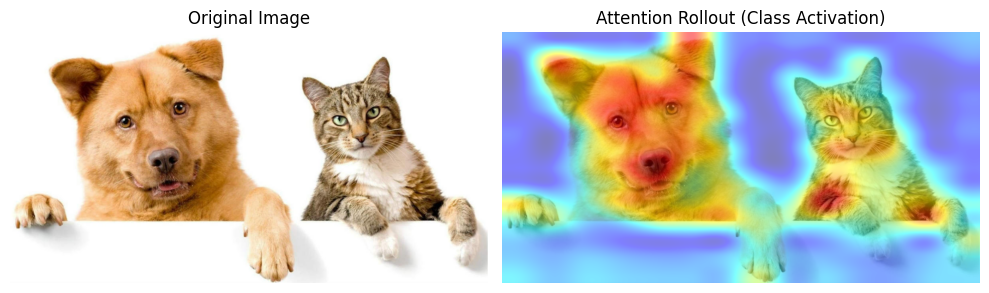

In [6]:
# Plot
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(image_np)
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Attention Rollout (Class Activation)")
plt.imshow(overlay)
plt.axis('off')

plt.tight_layout()
plt.show()